In [1]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBRegressor
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, silhouette_score, adjusted_rand_score, mean_squared_error, r2_score,mean_absolute_error)
from imblearn.under_sampling import RandomUnderSampler
import warnings 
warnings.filterwarnings('ignore')

df= pd.read_csv('creditcard.csv')
print(f"Dataset Shape: {df.shape}")
print(f"Fraud Precentage: {(df['Class'].value_counts()[1]/len(df))*100:4f}%")

Dataset Shape: (284807, 31)
Fraud Precentage: 0.172749%


In [2]:
print(df.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [3]:
#Data Preprocessing
print("Missing Values:", df.isnull().sum().sum())

#Features Scalling for TIme and Amount
scaler = StandardScaler()
df['Scaled_Time'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))
df['Scaled_Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))

#Drop original Time and Amount columns
df=df.drop(['Time','Amount'],axis=1)

#Handle class imblance 
from imblearn.under_sampling import RandomUnderSampler
X=df.drop('Class',axis=1)
y = df['Class']

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X,y)

print("After Resampling:")
print("Shape:", X_resampled.shape)


Missing Values: 0
After Resampling:
Shape: (984, 30)


In [4]:
#Data splitting for Classification and clustring
X_train,X_test,y_train,y_test= train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (688, 30)
Testing set shape: (296, 30)


In [5]:
# FEATURE ENGINEERING 
print("FEATURE ENGINEERING")

# 1️⃣ Create new interaction and ratio-based features
df['V1_V2_Interaction'] = df['V1'] * df['V2']
df['V3_V4_Interaction'] = df['V3'] * df['V4']
df['Scaled_Ratio'] = df['Scaled_Amount'] / (df['Scaled_Time'] + 1)  

# 2️⃣ Add polynomial features for selected columns
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df[['V1', 'V2', 'V3']])
poly_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(['V1', 'V2', 'V3']))
df = pd.concat([df.reset_index(drop=True), poly_df], axis=1)

# 3️⃣ Feature selection (remove low variance features)
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.01)
selected = selector.fit_transform(df.drop('Class', axis=1))
selected_features = df.drop('Class', axis=1).columns[selector.get_support()]
df = pd.concat([pd.DataFrame(selected, columns=selected_features), df['Class'].reset_index(drop=True)], axis=1)

print(f"New Shape after Feature Engineering: {df.shape}")
print("Sample columns after engineering:", df.columns[:10].tolist())

FEATURE ENGINEERING
New Shape after Feature Engineering: (284807, 43)
Sample columns after engineering: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10']


In [6]:
# UNDER-SAMPLING 
print("UNDER-SAMPLING TO BALANCE THE DATA")

# Separate features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Display original class distribution
print("Original Class Distribution:")
print(y.value_counts())
print(f"Original Dataset Shape: {X.shape}")

# Apply Random Under Sampling
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

# Display balanced class distribution
print("\nAfter Under-Sampling:")
print(y_resampled.value_counts())
print(f"Resampled Dataset Shape: {X_resampled.shape}")

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)

# Print shape details for clarity
print("\nTrain/Test Split:")
print(f"X_train Shape: {X_train.shape}")
print(f"X_test Shape:  {X_test.shape}")
print(f"y_train Class Distribution:\n{y_train.value_counts()}")
print(f"y_test Class Distribution:\n{y_test.value_counts()}")


UNDER-SAMPLING TO BALANCE THE DATA
Original Class Distribution:
Class
0    284315
1       492
Name: count, dtype: int64
Original Dataset Shape: (284807, 42)

After Under-Sampling:
Class
0    492
1    492
Name: count, dtype: int64
Resampled Dataset Shape: (984, 42)

Train/Test Split:
X_train Shape: (688, 42)
X_test Shape:  (296, 42)
y_train Class Distribution:
Class
1    344
0    344
Name: count, dtype: int64
y_test Class Distribution:
Class
0    148
1    148
Name: count, dtype: int64


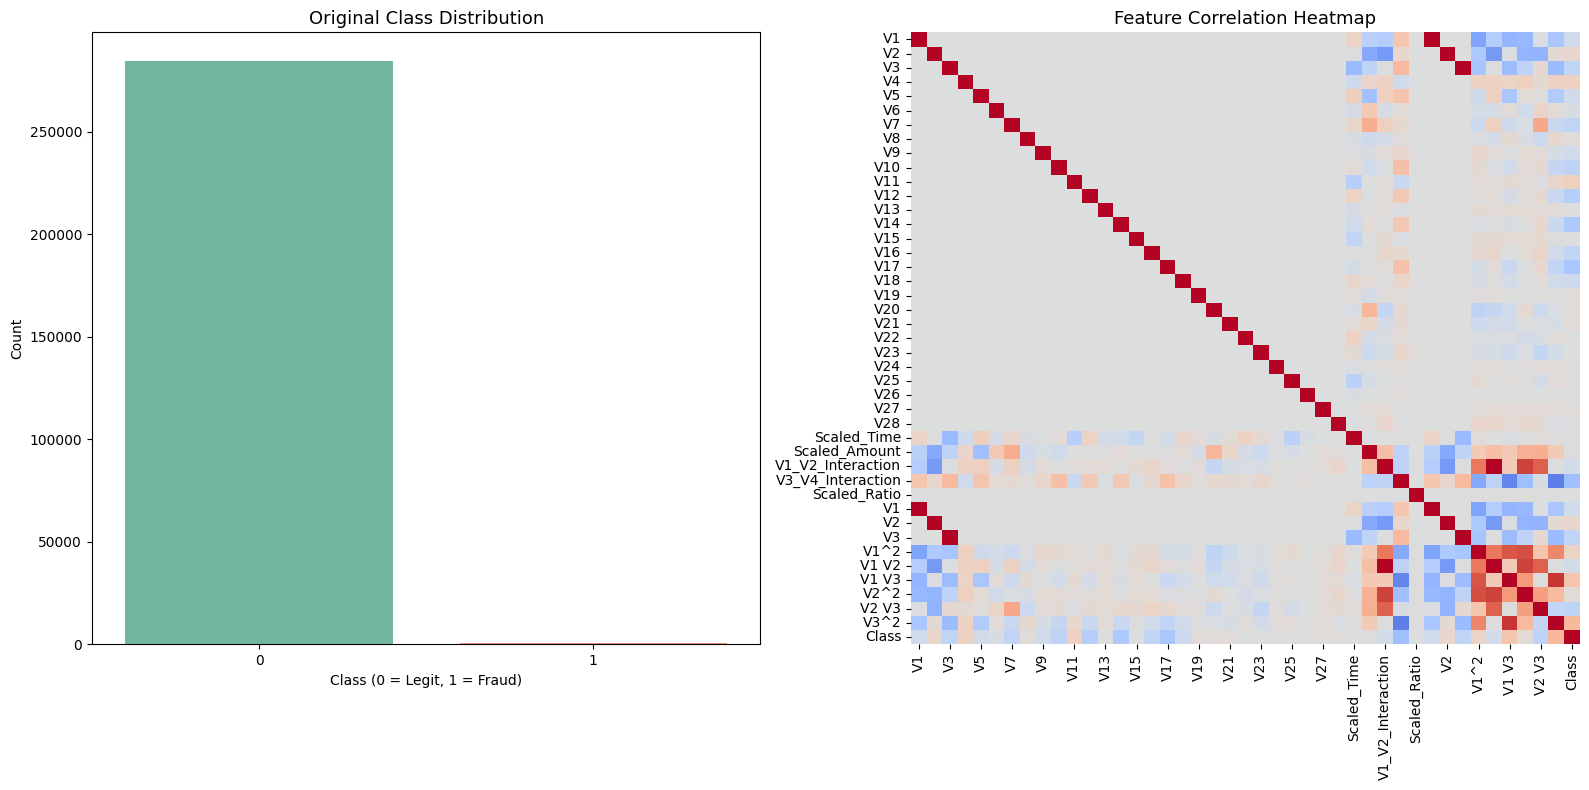

In [7]:
# EDA VISUALIZATIONS 
plt.figure(figsize=(16, 8))

# 1. Class Distribution
plt.subplot(1, 2, 1)
sns.countplot(x=y, palette='Set2')
plt.title("Original Class Distribution", fontsize=13)
plt.xlabel("Class (0 = Legit, 1 = Fraud)")
plt.ylabel("Count")

# 2. Feature Correlation Heatmap
plt.subplot(1, 2, 2)
sns.heatmap(df.corr(), cmap="coolwarm", center=0, cbar=False)
plt.title("Feature Correlation Heatmap", fontsize=13)
plt.tight_layout()
plt.show()

In [8]:
#Target for regression
df_original = pd.read_csv('creditcard.csv')

X_reg = df_original.drop(['Amount','Class','Time'],axis=1)
y_reg = df_original['Amount']

X_reg_train,X_reg_test,y_reg_train,y_reg_test= train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)

print("Regression Data Shapes:")
print("X_reg_train:", X_reg_train.shape)
print("X_reg_test:", X_reg_test.shape)

Regression Data Shapes:
X_reg_train: (199364, 28)
X_reg_test: (85443, 28)


{'Accuracy': 0.9493243243243243, 'Precision': 0.9854014598540146, 'Recall': 0.9121621621621622, 'F1': 0.9473684210526315, 'ROC-AOC': 0.9809852081811541}


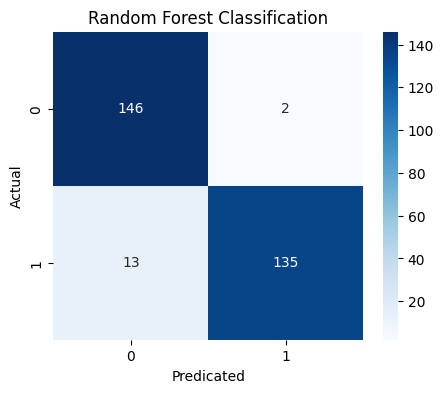

In [9]:
#Random Forest

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)

rf_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf),
    'Recall': recall_score(y_test, y_pred_rf),
    'F1':f1_score(y_test, y_pred_rf),
    'ROC-AOC': roc_auc_score(y_test, rf_classifier.predict_proba(X_test)[:,1])
}
print(rf_metrics)

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True ,fmt ='d', cmap='Blues')
plt.title("Random Forest Classification")
plt.xlabel("Predicated")
plt.ylabel("Actual")
plt.show()

In [10]:
#SVM

svm_classifier = SVC(kernel='rbf', probability = True, random_state=42)
svm_classifier.fit(X_train, y_train)
y_pred_svm= svm_classifier.predict(X_test)

svm_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_svm),
    'Precision': precision_score(y_test, y_pred_svm),
    'Recall': recall_score(y_test, y_pred_svm),
    'F1':f1_score(y_test, y_pred_svm),
    'ROC-AUC': roc_auc_score(y_test, svm_classifier.predict_proba(X_test)[:,1])
}

print(svm_metrics)

{'Accuracy': 0.8277027027027027, 'Precision': 0.98989898989899, 'Recall': 0.6621621621621622, 'F1': 0.7935222672064778, 'ROC-AUC': 0.9577702702702703}


   Feature  Importance
6       V7    0.189997
1       V2    0.146549
20     V21    0.098909
9      V10    0.088042
19     V20    0.084379
12     V13    0.063598
4       V5    0.045034
7       V8    0.037168
22     V23    0.037059
25     V26    0.023625


Text(0.5, 1.0, 'XGBoost: Actual vs Predicated Amounts')

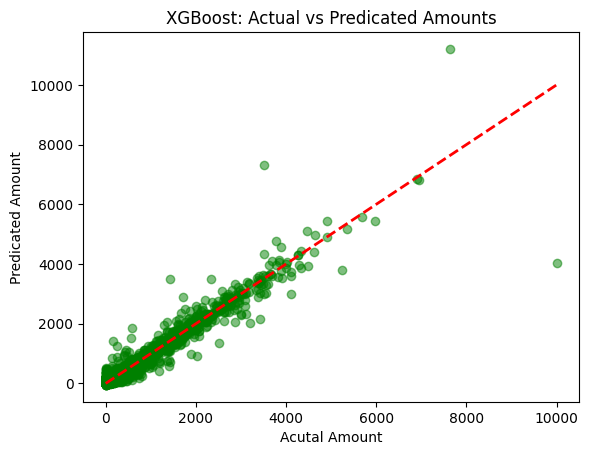

In [11]:
#XGBooost Regressor
xgb_regressor = XGBRegressor(n_estimators=100, learning_rate= 0.1, max_depth=6, random_state=42, n_jobs=-1)
xgb_regressor.fit(X_reg_train, y_reg_train)
y_pred_xgb = xgb_regressor.predict(X_reg_test)

xgb_metrics={
    'MAE' : mean_absolute_error(y_reg_test, y_pred_xgb),
    'RMSE' : np.sqrt(mean_squared_error(y_reg_test, y_pred_xgb)),
    'R2' : r2_score(y_reg_test, y_pred_xgb)
}

feature_imp = pd.DataFrame({
    'Feature': X_reg.columns,
    'Importance': xgb_regressor.feature_importances_
}).sort_values('Importance', ascending= False)

print(feature_imp.head(10))
plt.scatter(y_reg_test, y_pred_xgb, alpha=0.5, color='green')
plt.plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 'r--', lw=2)
plt.xlabel('Acutal Amount')
plt.ylabel('Predicated Amount')
plt.title('XGBoost: Actual vs Predicated Amounts')

Clustering Accuracy: 0.5497967479674797
Silhouette Score: 0.9003543808979232


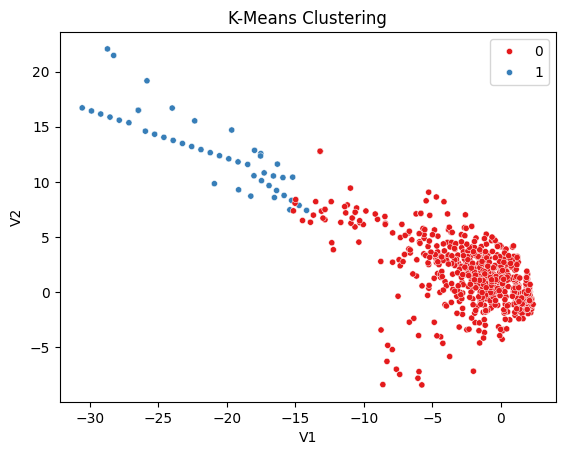

In [13]:
#k-means Clustring
kmeans = KMeans(n_clusters = 2, random_state=42)
clusters = kmeans.fit_predict(X_resampled)

from scipy.stats import mode
labels = np.zeros_like(clusters)
for i in range(2):
    mask = (clusters == i)
    labels[mask] = mode(y_resampled[mask])[0]

print("Clustering Accuracy:", accuracy_score(y_resampled, labels))
print("Silhouette Score:", silhouette_score(X_resampled, clusters))

sns.scatterplot(x=X_resampled.iloc[:,0], y=X_resampled.iloc[:,1], hue=labels, palette='Set1', s=20)
plt.title("K-Means Clustering")
plt.show()

In [14]:
#Linear regression
linear_reg = LinearRegression()
linear_reg.fit(X_reg_train, y_reg_train)
y_pred_linear = linear_reg.predict(X_reg_test)

lin_metrics={
    'MAE' : mean_absolute_error(y_reg_test, y_pred_linear),
    'RMSE' : np.sqrt(mean_squared_error(y_reg_test, y_pred_linear)),
    'R2' : r2_score(y_reg_test, y_pred_linear)
}
print(lin_metrics)

{'MAE': 24.392299783055115, 'RMSE': np.float64(64.64933864908876), 'R2': 0.9206945924499264}


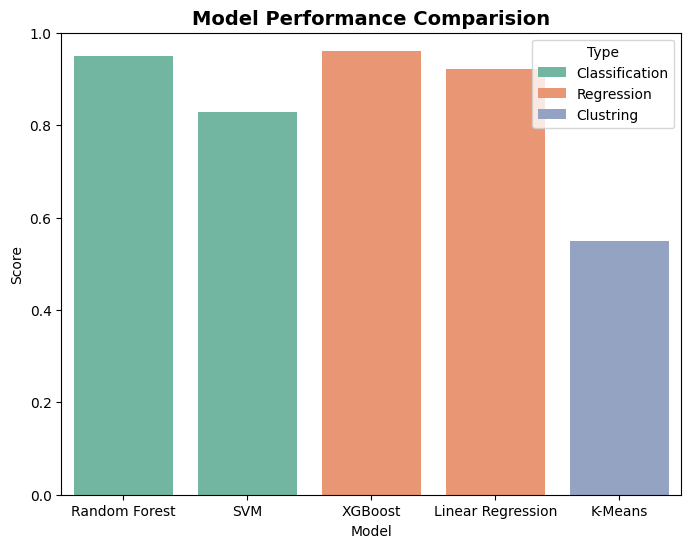

In [15]:
#comparision
comparison_df=pd.DataFrame({
    'Model':['Random Forest', 'SVM', 'XGBoost', 'Linear Regression', 'K-Means'],
    'Score': [
        rf_metrics['Accuracy'],
        svm_metrics['Accuracy'],
        xgb_metrics['R2'],
        lin_metrics['R2'],
        accuracy_score(y_resampled, labels)
    ],
    'Type': ['Classification', 'Classification', 'Regression', 'Regression', 'Clustring']
})
plt.figure(figsize=(8,6))
sns.barplot(x='Model', y='Score', hue='Type', data=comparison_df, palette= 'Set2')
plt.title("Model Performance Comparision", fontsize=14, fontweight='bold')
plt.ylim(0,1)
plt.show()

XGBoost- MAE: 17.56
Linear Regression- MAE: 24.39


<function matplotlib.pyplot.show(close=None, block=None)>

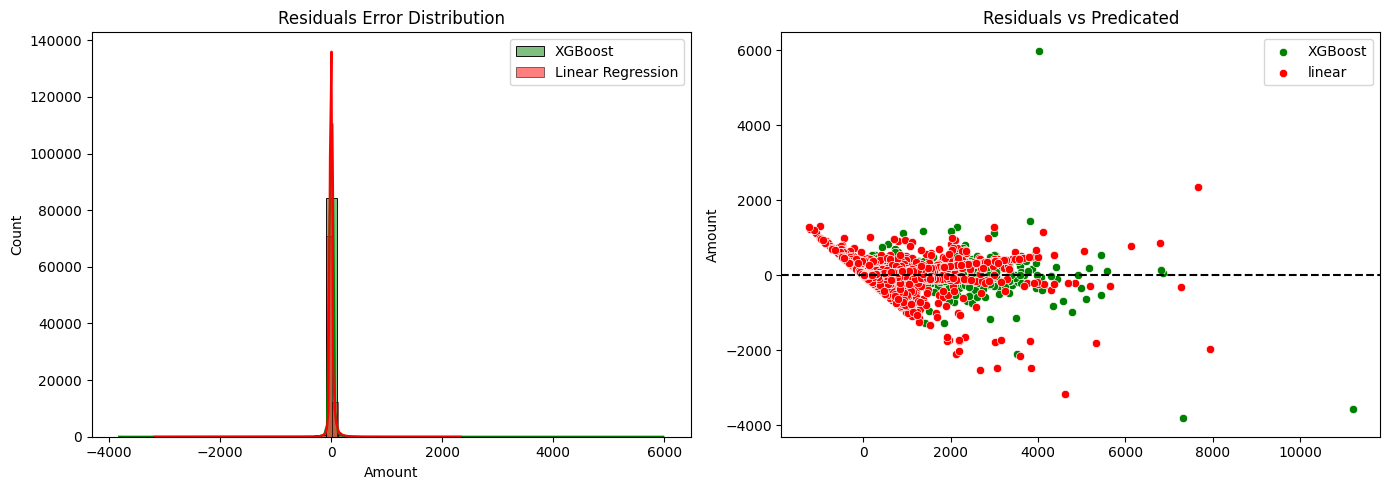

In [16]:
#error analysis
residuals_xgb = y_reg_test - y_pred_xgb
residuals_linear = y_reg_test - y_pred_linear

print(f"XGBoost- MAE: {mean_absolute_error(y_reg_test, y_pred_xgb):.2f}")
print(f"Linear Regression- MAE: {mean_absolute_error(y_reg_test, y_pred_linear):.2f}")

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
sns.histplot(residuals_xgb, color='green', bins=50, label= 'XGBoost', kde=True)
sns.histplot(residuals_linear, color='red', bins=50, label= 'Linear Regression', kde=True)
plt.legend()
plt.title("Residuals Error Distribution")

plt.subplot(1,2,2)
sns.scatterplot(x=y_pred_xgb, y=residuals_xgb, color='green', label= 'XGBoost')
sns.scatterplot(x=y_pred_linear, y=residuals_linear, color='red', label= 'linear')
plt.axhline(0, color='black', linestyle='--')
plt.title("Residuals vs Predicated")
plt.legend()
plt.tight_layout()
plt.show
